In [56]:
!ls /kaggle/input

dfdc-f150


In [57]:
!ls /kaggle/input/dfdc-f150

fake  real


In [58]:
!ls /kaggle/input/dfdc-f150 | head

fake
real


In [59]:
ROOT = "/kaggle/input/dfdc-f150"   # change this if your dataset name/path is different
REAL_DIR = f"{ROOT}/real"
FAKE_DIR = f"{ROOT}/fake"

In [60]:
!find /kaggle/input/dfdc-f150 -maxdepth 2 -type d

/kaggle/input/dfdc-f150
/kaggle/input/dfdc-f150/fake
^C


In [61]:
!ls /kaggle/input
!ls /kaggle/input/dfdc-f150

dfdc-f150
fake  real


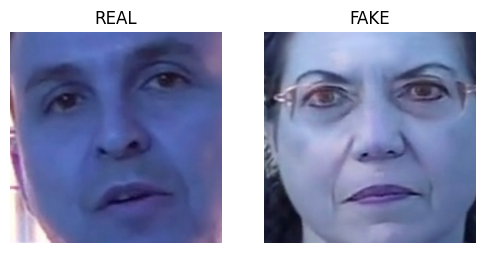

In [83]:
from PIL import Image
import matplotlib.pyplot as plt
import random, os

def show_random(folder, label):
    img = random.choice(os.listdir(folder))
    img = Image.open(os.path.join(folder, img))
    plt.imshow(img)
    plt.axis("off")
    plt.title(label)

plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
show_random(REAL_DIR, "REAL")
plt.subplot(1,2,2)
show_random(FAKE_DIR, "FAKE")
plt.show()

In [84]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

class DFDCFrameDataset(Dataset):
    def __init__(self, root):
        self.samples = []
        for label, cls in enumerate(["real", "fake"]):
            cls_dir = os.path.join(root, cls)
            for img in os.listdir(cls_dir):
                self.samples.append((os.path.join(cls_dir, img), label))

        self.transform = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("RGB")
        return self.transform(img), label

In [109]:
from torch.utils.data import random_split, DataLoader

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(
    train_ds,
    batch_size=32,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

val_loader = DataLoader(
    val_ds,
    batch_size=32,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

In [110]:
import torchvision.models as models
import torch.nn as nn

weights = models.ConvNeXt_Tiny_Weights.DEFAULT
model = models.convnext_tiny(weights=weights)

# Freeze backbone
for param in model.features.parameters():
    param.requires_grad = False

# Replace classifier
model.classifier[2] = nn.Linear(
    model.classifier[2].in_features, 2
)

model = model.to(device)

In [111]:
def accuracy(logits, labels):
    preds = logits.argmax(dim=1)
    return (preds == labels).float().mean().item()

In [112]:
import torch, os
print("cuda available:", torch.cuda.is_available())
print("gpu name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "NONE")

cuda available: True
gpu name: Tesla T4


In [113]:
from torch.utils.data import random_split

# ---------- Train / Val Split ----------
dataset = DFDCFrameDataset("/kaggle/input/dfdc-f150")

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(
    dataset, [train_size, val_size]
)

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

# ---------- Accuracy Function ----------
def accuracy(logits, labels):
    preds = torch.argmax(logits, dim=1)
    return (preds == labels).float().mean().item()

In [116]:
import time
from tqdm.auto import tqdm
import torch

torch.backends.cudnn.benchmark = True  # speedup for fixed-size images

print("cuda available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("gpu name:", torch.cuda.get_device_name(0))

cuda available: True
gpu name: Tesla T4


In [121]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm
import time

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

EPOCHS = 5

use_amp = (device == "cuda")
scaler = torch.amp.GradScaler("cuda") if use_amp else None

best_val_acc = 0.0

for epoch in range(EPOCHS):
    t0 = time.time()

    # ========== TRAIN ==========
    model.train()
    train_loss, train_acc = 0.0, 0.0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [TRAIN]", leave=False)
    for imgs, labels in pbar:
        imgs = imgs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        if use_amp:
            with torch.amp.autocast(device_type="cuda"):
                logits = model(imgs)
                loss = criterion(logits, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            logits = model(imgs)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

        acc = (logits.argmax(1) == labels).float().mean().item()
        train_loss += loss.item()
        train_acc += acc

        pbar.set_postfix(loss=loss.item(), acc=acc)

    train_loss /= len(train_loader)
    train_acc /= len(train_loader)

    # ========== VAL ==========
    model.eval()
    val_loss, val_acc = 0.0, 0.0

    vbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [VAL]", leave=False)
    with torch.no_grad():
        for imgs, labels in vbar:
            imgs = imgs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            if use_amp:
                with torch.amp.autocast(device_type="cuda"):
                    logits = model(imgs)
                    loss = criterion(logits, labels)
            else:
                logits = model(imgs)
                loss = criterion(logits, labels)

            acc = (logits.argmax(1) == labels).float().mean().item()
            val_loss += loss.item()
            val_acc += acc

            vbar.set_postfix(loss=loss.item(), acc=acc)

    val_loss /= len(val_loader)
    val_acc /= len(val_loader)

    # print epoch summary
    print(
        f"Epoch {epoch+1}/{EPOCHS} | "
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
        f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f} | "
        f"Time: {time.time()-t0:.1f}s"
    )

    # save best
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")
        print(f"✅ Saved best_model.pth (val_acc={best_val_acc:.4f})")

Epoch 1/5 [TRAIN]:   0%|          | 0/2354 [00:00<?, ?it/s]

Epoch 1/5 [VAL]:   0%|          | 0/589 [00:00<?, ?it/s]

Epoch 1/5 | Train Loss: 0.3830, Train Acc: 0.8393 | Val Loss: 0.3801, Val Acc: 0.8389 | Time: 439.7s
✅ Saved best_model.pth (val_acc=0.8389)


Epoch 2/5 [TRAIN]:   0%|          | 0/2354 [00:00<?, ?it/s]

Epoch 2/5 [VAL]:   0%|          | 0/589 [00:00<?, ?it/s]

Epoch 2/5 | Train Loss: 0.3815, Train Acc: 0.8405 | Val Loss: 0.3781, Val Acc: 0.8394 | Time: 335.3s
✅ Saved best_model.pth (val_acc=0.8394)


Epoch 3/5 [TRAIN]:   0%|          | 0/2354 [00:00<?, ?it/s]

Epoch 3/5 [VAL]:   0%|          | 0/589 [00:00<?, ?it/s]

Epoch 3/5 | Train Loss: 0.3772, Train Acc: 0.8423 | Val Loss: 0.3776, Val Acc: 0.8387 | Time: 317.3s


Epoch 4/5 [TRAIN]:   0%|          | 0/2354 [00:00<?, ?it/s]

Epoch 4/5 [VAL]:   0%|          | 0/589 [00:00<?, ?it/s]

Epoch 4/5 | Train Loss: 0.3763, Train Acc: 0.8428 | Val Loss: 0.3732, Val Acc: 0.8423 | Time: 319.1s
✅ Saved best_model.pth (val_acc=0.8423)


Epoch 5/5 [TRAIN]:   0%|          | 0/2354 [00:00<?, ?it/s]

Epoch 5/5 [VAL]:   0%|          | 0/589 [00:00<?, ?it/s]

Epoch 5/5 | Train Loss: 0.3751, Train Acc: 0.8440 | Val Loss: 0.3717, Val Acc: 0.8442 | Time: 321.6s
✅ Saved best_model.pth (val_acc=0.8442)


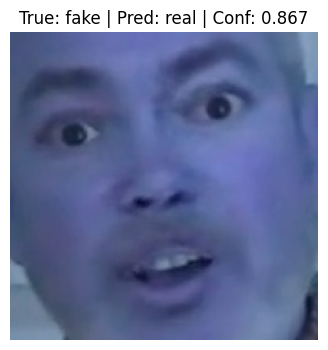

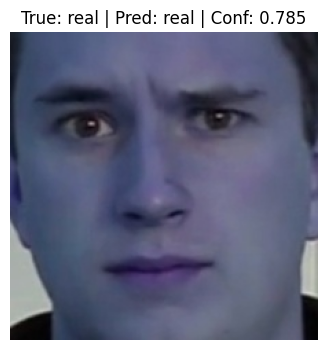

In [122]:
import random
import os
from PIL import Image
import matplotlib.pyplot as plt
import torch

# load best model
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.eval()

ROOT = "/kaggle/input/dfdc-f150"
class_names = ["fake", "real"]  # must match dataset order

def predict_image(path):
    img = Image.open(path).convert("RGB")
    x = dataset.transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(x)
        probs = torch.softmax(logits, dim=1)
        pred = probs.argmax(1).item()
        conf = probs[0, pred].item()

    return pred, conf, img

# test 4 random images
for cls in class_names:
    folder = os.path.join(ROOT, cls)
    fname = random.choice(os.listdir(folder))
    path = os.path.join(folder, fname)

    pred, conf, img = predict_image(path)

    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"True: {cls} | Pred: {class_names[pred]} | Conf: {conf:.3f}")
    plt.show()

In [124]:
final_results = {
    "model": "ConvNeXt-Tiny",
    "epochs": EPOCHS,
    "best_val_accuracy": best_val_acc,
    "dataset": "DFDC-F150",
    "image_size": "224x224",
    "optimizer": "AdamW",
    "learning_rate": 1e-4,
    "gpu": torch.cuda.get_device_name(0)
}

final_results

{'model': 'ConvNeXt-Tiny',
 'epochs': 5,
 'best_val_accuracy': 0.8441971866303267,
 'dataset': 'DFDC-F150',
 'image_size': '224x224',
 'optimizer': 'AdamW',
 'learning_rate': 0.0001,
 'gpu': 'Tesla T4'}

In [125]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        logits = model(imgs)
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=["fake", "real"]))

Confusion Matrix:
 [[  605  2738]
 [  201 15286]]

Classification Report:
              precision    recall  f1-score   support

        fake       0.75      0.18      0.29      3343
        real       0.85      0.99      0.91     15487

    accuracy                           0.84     18830
   macro avg       0.80      0.58      0.60     18830
weighted avg       0.83      0.84      0.80     18830



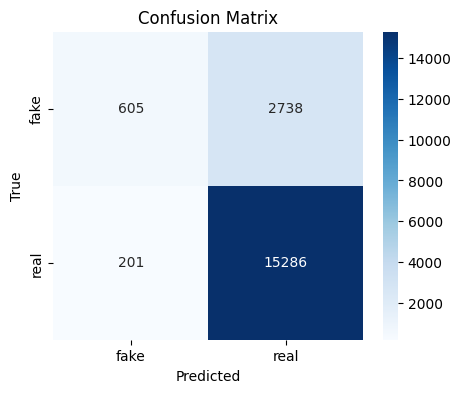

In [126]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=["fake","real"],
            yticklabels=["fake","real"],
            cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

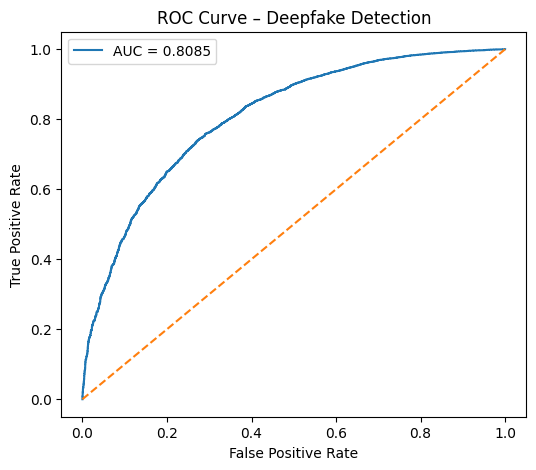

ROC-AUC Score: 0.8085


In [127]:
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

model.eval()
all_probs = []
all_labels = []

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        logits = model(imgs)
        probs = F.softmax(logits, dim=1)[:, 1]  # probability of "real"

        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Deepfake Detection")
plt.legend()
plt.show()

print(f"ROC-AUC Score: {roc_auc:.4f}")

In [129]:
import torchvision.models as models
import torch.nn as nn

weights = models.ConvNeXt_Tiny_Weights.DEFAULT
model = models.convnext_tiny(weights=weights)
model.classifier[2] = nn.Linear(model.classifier[2].in_features, 2)

model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.to(device)
model.eval()

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

In [130]:
import cv2
from torchvision import transforms
from PIL import Image
import numpy as np

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

def predict_video(video_path, frame_step=10):
    cap = cv2.VideoCapture(video_path)
    frame_preds = []

    frame_idx = 0
    with torch.no_grad():
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            if frame_idx % frame_step == 0:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                img = Image.fromarray(frame)
                img = transform(img).unsqueeze(0).to(device)

                logits = model(img)
                pred = torch.argmax(logits, dim=1).item()
                frame_preds.append(pred)

            frame_idx += 1

    cap.release()

    if len(frame_preds) == 0:
        return "No frames read"

    final_pred = max(set(frame_preds), key=frame_preds.count)
    return "REAL" if final_pred == 1 else "FAKE"

In [132]:
import os, glob

print("Top-level /kaggle/input:", os.listdir("/kaggle/input"))

mp4s = glob.glob("/kaggle/input/**/*.mp4", recursive=True)
movs = glob.glob("/kaggle/input/**/*.mov", recursive=True)
avi  = glob.glob("/kaggle/input/**/*.avi", recursive=True)

videos = mp4s + movs + avi
print("Total videos found:", len(videos))
print("\n".join(videos[:50]))  # shows first 50 paths

Top-level /kaggle/input: ['dfdc-f150']
Total videos found: 0



Total frames found: 94147


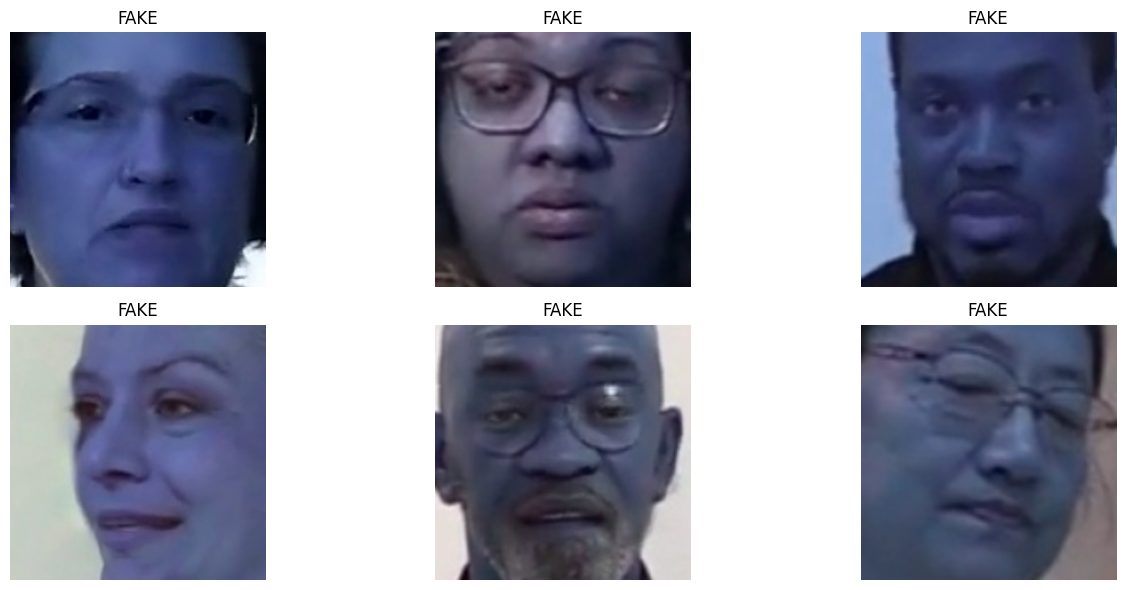

In [133]:
import glob, random
import torch
from PIL import Image
import matplotlib.pyplot as plt

# collect all image paths (jpg/png)
img_paths = glob.glob("/kaggle/input/dfdc-f150/**/*.jpg", recursive=True) + \
            glob.glob("/kaggle/input/dfdc-f150/**/*.png", recursive=True)

print("Total frames found:", len(img_paths))
assert len(img_paths) > 0, "No image frames found in dataset path!"

model.eval()

# show a few random predictions
N = 6
sample_paths = random.sample(img_paths, k=min(N, len(img_paths)))

plt.figure(figsize=(14, 6))
for i, p in enumerate(sample_paths, 1):
    img = Image.open(p).convert("RGB")
    x = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(x)
        pred = torch.argmax(logits, dim=1).item()  # 0=REAL, 1=FAKE

    label = "REAL" if pred == 0 else "FAKE"

    plt.subplot(2, 3, i)
    plt.imshow(img)
    plt.title(label)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [134]:
import os, glob, random
import torch
from PIL import Image
from collections import Counter

def predict_frames(paths, max_samples=30):
    """Predict REAL/FAKE for a list of frame paths and return majority vote + details."""
    model.eval()

    if len(paths) == 0:
        return None, {}

    # sample frames to speed up
    if len(paths) > max_samples:
        paths = random.sample(paths, max_samples)

    preds = []
    with torch.no_grad():
        for p in paths:
            img = Image.open(p).convert("RGB")
            x = transform(img).unsqueeze(0).to(device)
            logits = model(x)
            pred = torch.argmax(logits, dim=1).item()  # 0=REAL, 1=FAKE
            preds.append(pred)

    counts = Counter(preds)
    majority = counts.most_common(1)[0][0]
    final_label = "REAL" if majority == 0 else "FAKE"
    return final_label, dict(counts)

# ---- Example: run on the REAL folder and FAKE folder ----
real_paths = glob.glob("/kaggle/input/dfdc-f150/real/**/*.jpg", recursive=True) + \
             glob.glob("/kaggle/input/dfdc-f150/real/**/*.png", recursive=True)

fake_paths = glob.glob("/kaggle/input/dfdc-f150/fake/**/*.jpg", recursive=True) + \
             glob.glob("/kaggle/input/dfdc-f150/fake/**/*.png", recursive=True)

print("REAL frames:", len(real_paths))
print("FAKE frames:", len(fake_paths))

real_vote, real_counts = predict_frames(real_paths, max_samples=50)
fake_vote, fake_counts = predict_frames(fake_paths, max_samples=50)

print("Majority vote on REAL folder ->", real_vote, "| counts:", real_counts)
print("Majority vote on FAKE folder ->", fake_vote, "| counts:", fake_counts)

REAL frames: 16203
FAKE frames: 77944
Majority vote on REAL folder -> FAKE | counts: {0: 11, 1: 39}
Majority vote on FAKE folder -> FAKE | counts: {1: 50}


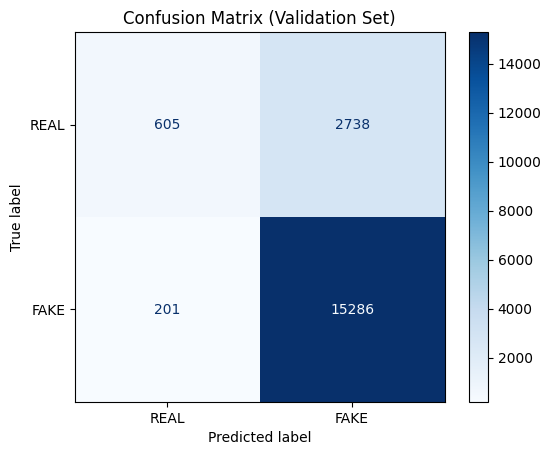

In [135]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        logits = model(imgs)
        preds = torch.argmax(logits, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["REAL", "FAKE"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (Validation Set)")
plt.show()

In [136]:
import torch.nn.functional as F
import numpy as np

probs = []
labels_all = []

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        logits = model(imgs)
        p = F.softmax(logits, dim=1)[:, 1]  # FAKE probability

        probs.extend(p.cpu().numpy())
        labels_all.extend(labels.numpy())

probs = np.array(probs)
labels_all = np.array(labels_all)

print("Mean FAKE prob for REAL frames:", probs[labels_all == 0].mean())
print("Mean FAKE prob for FAKE frames:", probs[labels_all == 1].mean())

Mean FAKE prob for REAL frames: 0.68168485
Mean FAKE prob for FAKE frames: 0.8597317


In [137]:
import numpy as np

thresholds = np.linspace(0.5, 0.9, 9)

for t in thresholds:
    preds = (probs > t).astype(int)
    acc = (preds == labels_all).mean()
    real_fp = ((preds == 1) & (labels_all == 0)).mean()
    print(f"Threshold {t:.2f} | Acc: {acc:.4f} | False FAKE on REAL: {real_fp:.4f}")

Threshold 0.50 | Acc: 0.8439 | False FAKE on REAL: 0.1454
Threshold 0.55 | Acc: 0.8480 | False FAKE on REAL: 0.1353
Threshold 0.60 | Acc: 0.8492 | False FAKE on REAL: 0.1232
Threshold 0.65 | Acc: 0.8433 | False FAKE on REAL: 0.1105
Threshold 0.70 | Acc: 0.8330 | False FAKE on REAL: 0.0930
Threshold 0.75 | Acc: 0.8075 | False FAKE on REAL: 0.0750
Threshold 0.80 | Acc: 0.7581 | False FAKE on REAL: 0.0560
Threshold 0.85 | Acc: 0.6762 | False FAKE on REAL: 0.0355
Threshold 0.90 | Acc: 0.5349 | False FAKE on REAL: 0.0166


In [140]:
FINAL_THRESHOLD = 0.75

def predict_with_threshold(logits):
    probs = torch.softmax(logits, dim=1)[:, 1]
    return (probs > FINAL_THRESHOLD).long()

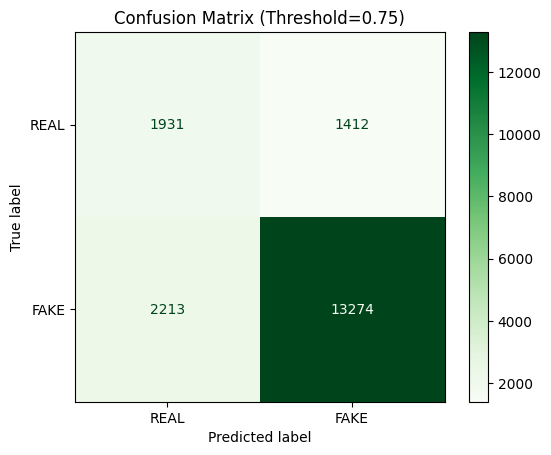

In [141]:
y_pred_thr = []

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        logits = model(imgs)
        preds = predict_with_threshold(logits)
        y_pred_thr.extend(preds.cpu().numpy())

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm_thr = confusion_matrix(y_true, y_pred_thr)

ConfusionMatrixDisplay(cm_thr, display_labels=["REAL", "FAKE"]).plot(cmap="Greens")
plt.title(f"Confusion Matrix (Threshold={FINAL_THRESHOLD})")
plt.show()